<div style="float: left">
  <img src='https://www.tu-clausthal.de/fileadmin/TU_Clausthal/images/CorporateDesign/Logo/Logo_TUC_de_Web.gif'>
</div>
<div style="float: right; font-size: 0.8em">
  <div style="margin-bottom: 0.8em">
    <span style="font-weight: bold; font-size: 1.2em;">Institut für Mathematik</span><br />
  </div>
    <div>
        Prof. Dr. Andreas Potschka<br />
        Kaisar Dawara
    </div>
  </div>
</div>

# TUC Drillbotics Trajectory Optimization Tool

## Abstract

The TUC Drillbotics team participates in the international Drillbotics competition, where the drilling trajectory must be planned through a set of goal points that are not aligned in a straight line. The planned trajectory will be executed by an autonomous miniature drilling rig. Constraints on the trajectory are imposed by the physical properties of the Bottom Hole Assembly (BHA).

---

## Introduction

In the context of the Drillbotics competition, a key challenge lies in the automated generation of drillable trajectories through a predefined set of 3D coordinates, all under mechanical and physical constraints. To facilitate the development and comparison of various trajectory planning algorithms, a systematic evaluation framework is required.

The goal of this project is to design and implement a **trajectory optimization and evaluation tool** that quantitatively assesses the output of different planning approaches.

---

## Task Description

The task is to program a tool that evaluates generated trajectories. The tool should accept either a **discrete** (sequence of waypoints) or **continuous** (parametric curve) representation of a trajectory and compute a **composite cost function** based on multiple, weighted evaluation criteria.

### Evaluation Criteria

The evaluation tool will compute a cost based on the following (customizable) metrics:

* **Total Path Length**
    Affects drilling time and material wear.

* **Cumulative Angular Deviation / Curvature**
    Penalizes sharp bends and infeasible transitions. Encourages smoother trajectories and discourages zigzag paths, even if each individual bend is mechanically feasible.

* **Mechanical Feasibility Constraints**
    Includes constraints such as maximum allowable deviation per segment and minimum radius of curvature.

* **Estimated Energy Consumption and Time**
    Based on the geometry of the path and expected drilling dynamics.

### Features

* Composite cost function for multi-objective evaluation.
* Support for sensitivity analysis (adjustable weights).
* Comparison and ranking of different trajectory planning algorithms.
* Modular design to allow future extensions.

### Purpose

The scalar cost produced by the tool provides a **quantitative and objective basis** for:

* Comparing and ranking trajectory planning algorithms.
* Supporting iterative algorithm optimization.
* Encouraging multi-objective optimization in planning strategies.
---

In [1]:
# importaions
from rockit import *
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Creating an Optimal Control Problem
ocp = Ocp(T=FreeTime(10)) # Guess for total arc length

In [3]:
# The state now has 6 dimensions: [x_pos, y_pos, z_pos, azimuth, inclination]
x_pos = ocp.state()
y_pos = ocp.state()
z_pos = ocp.state()
t = ocp.state()
azimuth = ocp.state()
inclination = ocp.state()


In [4]:
# Controls are now derivatives with respect to arc length 's'
u_azimuth_rate_ds = ocp.control()     # Represents u_1 = d(azimuth)/ds
u_inclination_rate_ds = ocp.control() # Represents u_2 = d(inclination)/ds
inverse_rop = ocp.control()           # Represents u_3 = 1/ROP = 1/speed
# inverse_rop1 = ocp.variable()

In [5]:

# Other Aproach to optimize the correct T for the solver
# T = ocp.variable() 
# L = sqrt(x_pos**2+y_pos**2+z_pos**2) # Straight line (fastes undrillable way)
# T_min = L/v # Straight-line time
# ocp.subject_to(T >= T_min) 
# ocp.set_initial(T, 1.2 * k_min) # init value with margin to avoid feasbility 

# v_x = v * ca.sin(inclination) * ca.cos(azimuth)
# v_y = v * ca.sin(inclination)* ca.sin(azimuth)
# v_z = v * ca.cos(inclination)

# The geometric part of the dynamics (speed has been factored out)
v_x_ds = ca.sin(inclination) * ca.cos(azimuth)
v_y_ds = ca.sin(inclination) * ca.sin(azimuth)
v_z_ds = ca.cos(inclination)

# Set the new derivatives with respect to 's'
ocp.set_der(x_pos, v_x_ds)
ocp.set_der(y_pos, v_y_ds)
ocp.set_der(z_pos, v_z_ds)
ocp.set_der(azimuth, u_azimuth_rate_ds)
ocp.set_der(inclination, u_inclination_rate_ds)

# dt/ds = 1 / speed = inverse_rop
ocp.set_der(t, inverse_rop)

In [6]:
# Define the Cost Function / goal

ocp.add_objective(ocp.at_tf(t))

In [7]:
# ======> Constraints / rules

# --- Initial Conditions ---
# Start at origin (0,0,0), pointing straight down.
# Azimuth pointing straight down '0'.
# Inclination is pi (180 degrees) for pointing down.

ocp.subject_to(ocp.at_t0(x_pos) == 0)
ocp.subject_to(ocp.at_t0(y_pos) == 0)
ocp.subject_to(ocp.at_t0(z_pos) == 0)
ocp.subject_to(ocp.at_t0(azimuth) == 0)
# Force the drill to always point downwards at the start 
ocp.subject_to(ocp.at_t0(inclination) == ca.pi)
ocp.subject_to(ocp.at_t0(t) == 0)

# --- Final Conditions ---
goal_point = [0, 0, -20]
ocp.subject_to(ocp.at_tf(x_pos) == goal_point[0])
ocp.subject_to(ocp.at_tf(y_pos) == goal_point[1])
ocp.subject_to(ocp.at_tf(z_pos) == goal_point[2])
# ocp.subject_to(ocp.at_tf(u_azimuth_rate_ds) == 0)
# ocp.subject_to(ocp.at_tf(u_inclination_rate_ds) == 0)

# --- Path Constraints (Control Limits) ---

max_bur = 0.05 # max build-up rate in rad/m
ocp.subject_to(u_inclination_rate_ds >= -max_bur)
ocp.subject_to(u_inclination_rate_ds <=  max_bur)
# -> In order to prevent the trajectory from going upwards and to force it to point downwards(iclination between 90 and 270 degrees):
# -> x_z = cos(I) for x_z < 0 => I in {pi/2, 3*pi/2}
ocp.subject_to(inclination >= ca.pi/2)
ocp.subject_to(inclination <= 3*ca.pi/2)

ocp.subject_to(u_azimuth_rate_ds >= -max_bur)
ocp.subject_to(u_azimuth_rate_ds <=  max_bur)

rop_max = 30 # max speed in m/min
rop_min = 5  # min speed (must be > 0)

# If rop_min <= ROP <= rop_max, then 1/rop_max <= 1/ROP <= 1/rop_min
ocp.subject_to(inverse_rop >= 1/rop_max)
ocp.subject_to(inverse_rop <= 1/rop_min)

In [8]:
# Solve the OCP
ocp.method(DirectCollocation(N=20))
ocp.solver('ipopt')
sol = ocp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4249
Number of nonzeros in inequality constraint Jacobian.:      169
Number of nonzeros in Lagrangian Hessian.............:      841

Total number of variables............................:      667
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      609
Total number of inequality c

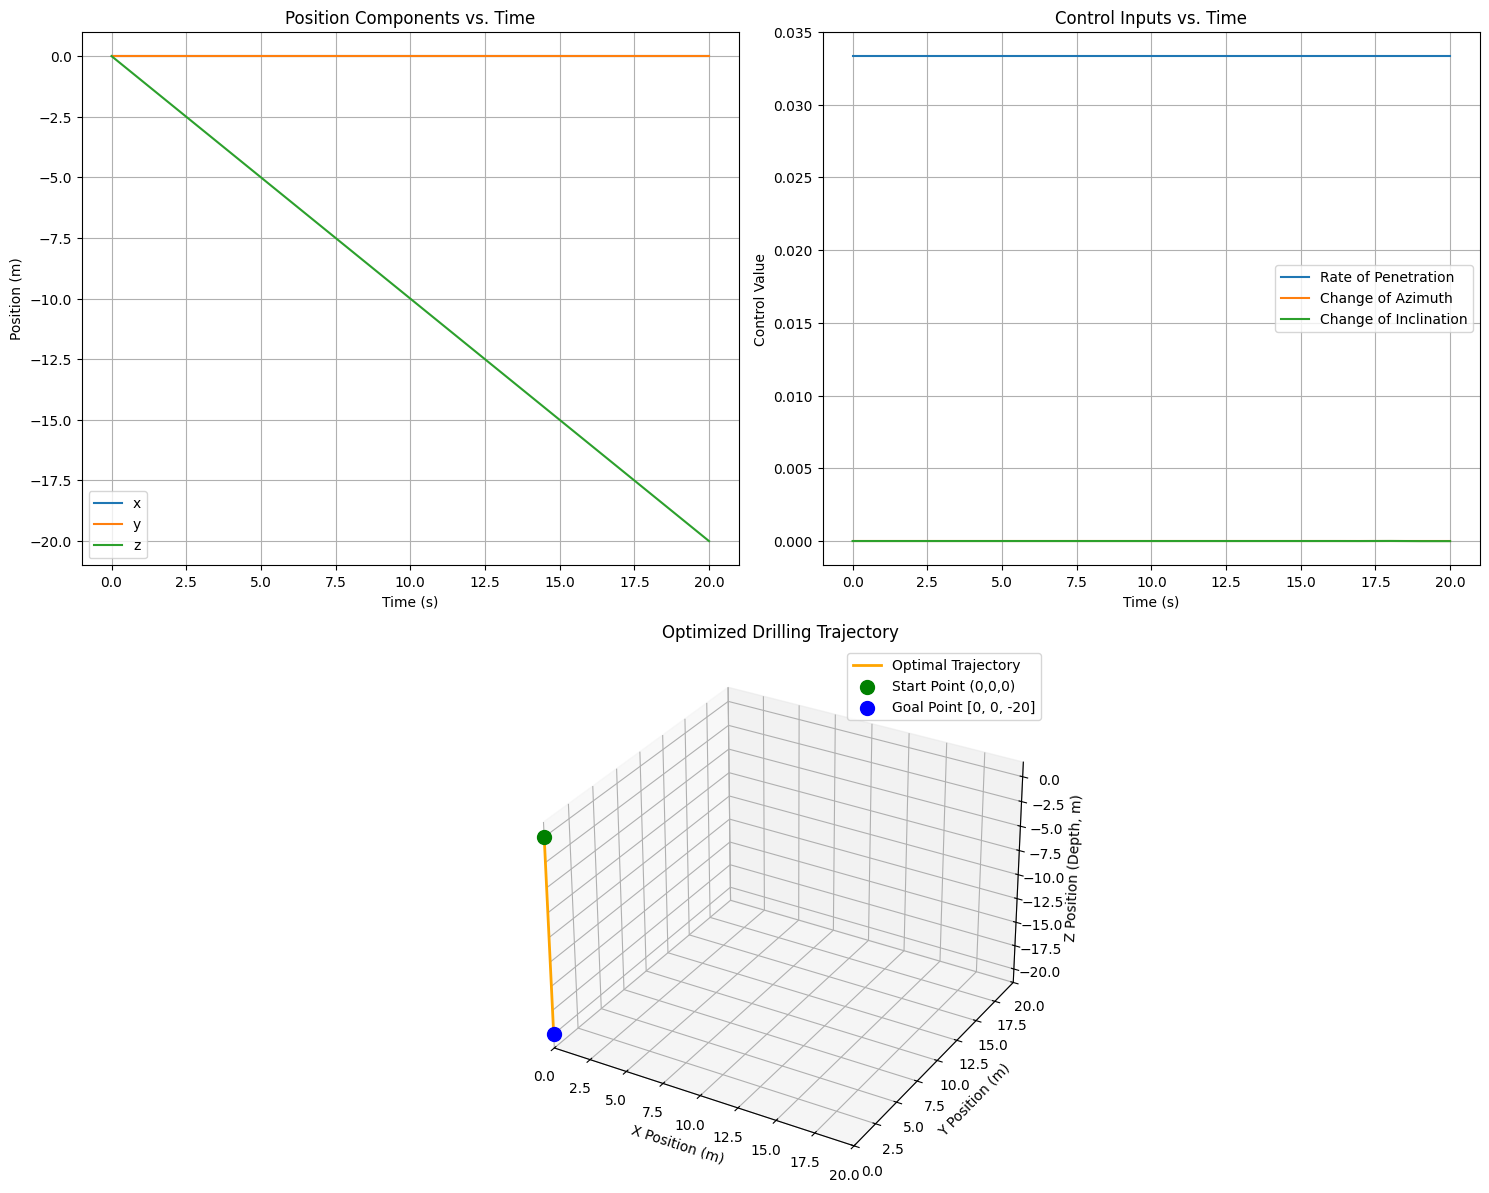

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3d = fig.add_subplot(2, 1, 2, projection='3d') # This subplot is for the 3D trajectory

# --- PLOT 1: Position vs. Time ---
ts, xs = sol.sample(x_pos, grid='integrator')
ax1.plot(ts, xs, label='x')
ts, ys = sol.sample(y_pos, grid='integrator')
ax1.plot(ts, ys, label='y')
ts, zs = sol.sample(z_pos, grid='integrator')
ax1.plot(ts, zs, label='z')
ts, xxs = sol.sample(x_pos, grid='control')
ax1.set_title("Position Components vs. Time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Position (m)")
ax1.legend()
ax1.grid(True)


# --- PLOT 2: Control Inputs vs. Time ---
ts, vs = sol.sample(inverse_rop, grid='control')
ax2.plot(ts, vs, label='Rate of Penetration')
ts, azimuth_s = sol.sample(u_azimuth_rate_ds, grid='control')
ax2.plot(ts, azimuth_s, label='Change of Azimuth')
ts, inclination_s = sol.sample(u_inclination_rate_ds, grid='control')
ax2.plot(ts, inclination_s, label='Change of Inclination')
ax2.set_title("Control Inputs vs. Time")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Control Value")
ax2.legend()
ax2.grid(True)


# --- PLOT 3: The 3D Trajectory ---
# The variables xs, ys, zs were already sampled for the first plot.
ax3d.plot(xs, ys, zs, label='Optimal Trajectory', linewidth=2, color='orange')
ax3d.scatter([0], [0], [0], c='green', s=100, label='Start Point (0,0,0)')
ax3d.scatter([goal_point[0]], [goal_point[1]], [goal_point[2]], c='blue', s=100, label=f'Goal Point {goal_point}')

# Set Labels, Title, and Legend
ax3d.set_xlabel("X Position (m)")
ax3d.set_ylabel("Y Position (m)")
ax3d.set_zlabel("Z Position (Depth, m)")
ax3d.set_title("Optimized Drilling Trajectory")
ax3d.legend()

# Set Axis Limits and Direction
ax3d.set_xlim(0, 20)
ax3d.set_ylim(0, 20)
# ax3d.invert_zaxis()
ax3d.invert_yaxis()
ax3d.invert_xaxis()

# Control the Viewing Angle
ax3d.view_init(elev=30, azim=120)


# --- Display EVERYTHING at Once ---
plt.tight_layout()
plt.show()